In [1]:
# Core analysis packages
import numpy as np
import os, sys
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import anova
from patsy import dmatrices
import bff
# Plotting packages
import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns 
sns.set(style="ticks", color_codes=True)
sns.set_style("white")
sns.set_style({'xtick.bottom': True, 'ytick.left': True})
colorref = ["gray", "royalblue", "crimson", "goldenrod", "mediumorchid", "seagreen"]


# iPython magic commands
%matplotlib notebook
%load_ext autoreload
%autoreload 2
%autosave 120

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIG_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)  # fontsize of the figure title
cust_palette = sns.color_palette("Paired")[6:10]
cust_palette = [cust_palette[i] for i in [1,0,3,2]]

def median_split(S):
    return S > S.median()

Autosaving every 120 seconds


In [2]:
# Load file (from same directory as the notebook)
df = pd.read_excel(os.path.expanduser("princeton200.xlsx"), index_col=0)
df.head()

,GENDER,AGE,PARTY,TWITTER,TRUST,RATIONALUPDATE,RU1,RU2,RU3,RU4,...,SPT30,SUT30,APT31,AUT31,SPT31,SUT31,APT32,AUT32,SPT32,SUT32
Response ID,,,,,,,,,,,,,,,,,,,,,
R_ykkxJ7f40bzTEaZ,1,19,1,0,89,NaN,-3,14,14,-13,...,NaN,NaN,NaN,61.0,NaN,NaN,6.0,NaN,NaN,NaN
R_25QiP0xNXVnRkAG,0,20,1,0,80,NaN,9,-1,-6,0,...,41.0,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,66.0
R_3oT29XOVAcoi7Rn,1,19,1,0,77,NaN,0,-3,11,-37,...,NaN,NaN,NaN,NaN,NaN,35.0,NaN,NaN,0.0,NaN
R_2vZJNUGD4ve7StK,1,19,3,0,95,NaN,10,1,-11,-23,...,NaN,73.0,34.0,NaN,NaN,NaN,NaN,43.0,NaN,NaN
R_31oOzglBXE0nZO6,1,20,1,0,80,NaN,-27,-32,20,25,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN


In [3]:
def get_condnum(X):
    return np.mod(np.where(X)[-1], 4)
def sample(data, locs):
    idx = locs + 4*np.arange(locs.size)
    return data[idx]

In [4]:
# Extract columns with df.target or df["target"] or df.loc[:,"target"]
age = df.loc[:, "AGE"]
party = df.loc[:, "PARTY"]
twitter = df.loc[:, "TWITTER"]
trust = df.loc[:,"TRUST"]
partnum = np.arange(trust.size)

In [5]:
# Extract data with df.loc[:,"datastart":"dataend"]
RdeltaB = df.loc[:, "RU1":"RU32"]
convincing = df.loc[:, "APT1":"SUT32"]

cond_place = np.logical_not(np.isnan(convincing))

sz = RdeltaB.shape
itemnum = np.arange(sz[-1])
print(sz)

(200, 32)


In [6]:
#Compress condition-wise data into a single data matrix and labels
cond = np.array([get_condnum(cond_place.iloc[i,:]) for i in range(sz[0])])
# ^ Labels
convincing = np.array([sample(convincing.iloc[i], cond[i]) for i in range(sz[0])])

In [8]:
# Data and row-wise labels first
names = ["RdeltaB", "convincing", "cond", "itemnum", \
         "age", "party", "twitter", "trust", "partnum"]
data_packed = np.broadcast_arrays(RdeltaB, convincing, cond, itemnum)
# Then column-wise labels
cols = [np.tile(a, (sz[1],1)).T for a in [age, party, twitter, trust, partnum]]
data_packed += cols

data_unpacked = np.vstack([np.reshape(a, (1,-1), order="C") for a in data_packed]).T
DATA = pd.DataFrame(data=data_unpacked, columns=names)

ticklbl = ["Anec, Norm","Anec, Non-Norm","Sci, Norm","Sci, Non-Norm"]

DATA.head()

,RdeltaB,convincing,cond,itemnum,age,party,twitter,trust,partnum
0,-3.0,77.0,2.0,0.0,19.0,1.0,0.0,89.0,0.0
1,14.0,17.0,1.0,1.0,19.0,1.0,0.0,89.0,0.0
2,14.0,44.0,2.0,2.0,19.0,1.0,0.0,89.0,0.0
3,-13.0,15.0,0.0,3.0,19.0,1.0,0.0,89.0,0.0
4,-2.0,59.0,0.0,4.0,19.0,1.0,0.0,89.0,0.0


In [9]:
# Group and average data within participant and PE bin
AVDATA = DATA.groupby(["partnum", "cond"], as_index=False).mean()
AVDATA.head()

,partnum,cond,RdeltaB,convincing,itemnum,age,party,twitter,trust
0,0.0,0.0,-0.909091,35.181818,16.454545,19.0,1.0,0.0,89.0
1,0.0,1.0,-1.375000,33.875000,17.250000,19.0,1.0,0.0,89.0
2,0.0,2.0,2.714286,52.142857,13.571429,19.0,1.0,0.0,89.0
3,0.0,3.0,-4.166667,41.666667,13.666667,19.0,1.0,0.0,89.0
4,1.0,0.0,1.909091,54.909091,12.181818,20.0,1.0,0.0,80.0


<IPython.core.display.Javascript object>


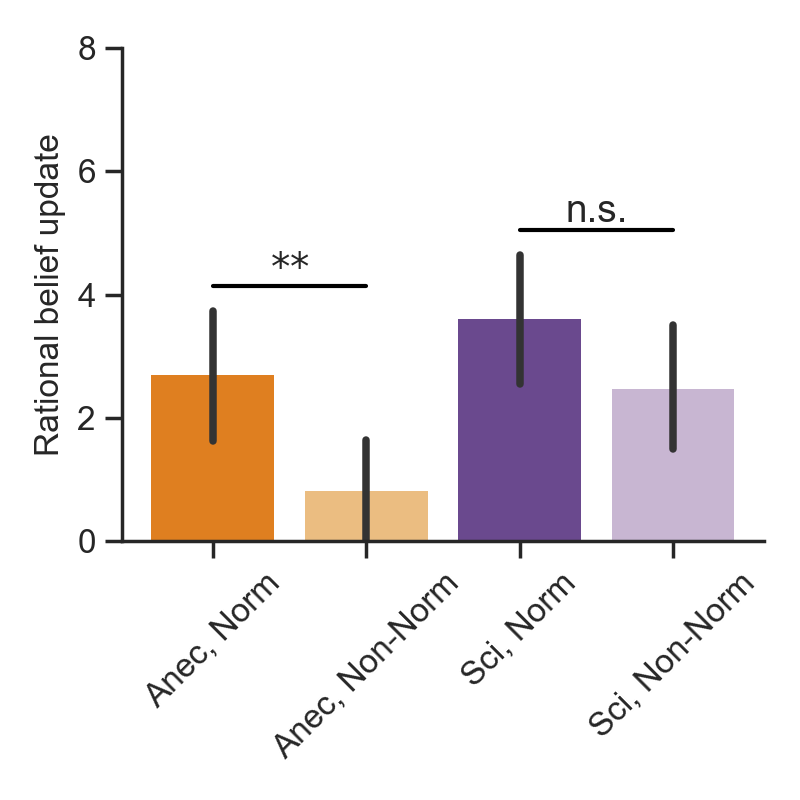

In [10]:
yax = "RdeltaB"
# Plotting
fig, ax = plt.subplots(1,1, figsize=(4,4))
sns.barplot(x="cond", y="RdeltaB", data=AVDATA, \
            palette=cust_palette, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax) 
sns.despine()
ax.set_xlabel("");
ax.set_xticklabels(["Anec", "Sci"])
ax.set_xticklabels(ticklbl, rotation=45);
ax.set_ylabel("Rational belief update");
plt.ylim(0,8)
# Significance testing
datahandles = np.array([L.get_xydata() for L in ax.get_lines()])
_, p = stats.ttest_ind(AVDATA.loc[AVDATA["cond"]==0, yax], \
                       AVDATA.loc[AVDATA["cond"]==1, yax], equal_var=False)
bff.barplot_annotate_brackets(ax, 0, 1, p, datahandles, dh=0.05, fs=14)
_, p = stats.ttest_ind(AVDATA.loc[AVDATA["cond"]==3, yax], \
                       AVDATA.loc[AVDATA["cond"]==2, yax], equal_var=False)
bff.barplot_annotate_brackets(ax, 3, 2, p, datahandles, dh=0.05, fs=14)


plt.tight_layout()
#plt.savefig('fig1p.tif', dpi=300, format="tiff")

<IPython.core.display.Javascript object>


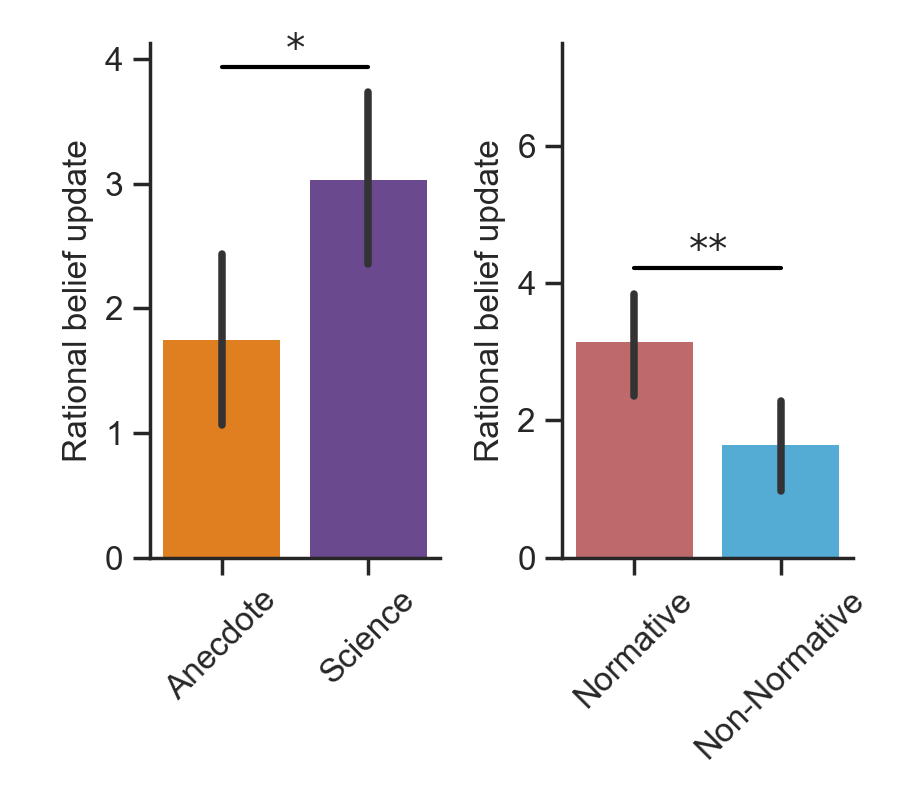

In [12]:
# Group and average data within participant and PE bin
AVDATA = DATA.groupby(["partnum", "cond"], as_index=False).mean()

if "sci_anec" not in AVDATA:
    AVDATA.insert(2, "sci_anec", AVDATA["cond"].apply(lambda x: np.int(np.greater_equal(x, 1.5))))
    AVDATA.insert(2, "pop_unpop", AVDATA["cond"].apply(lambda x: np.mod(x, 2)))

pal=[(205/255, 92/255, 92/255), (0.246, 0.700, 0.910)]

# Plotting
fig, ax = plt.subplots(1,2, figsize=(4.5,4))
sns.barplot(x="sci_anec", y="RdeltaB", data=AVDATA, \
            palette=cust_palette[0::2], linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[0]) 
sns.despine()
ax[0].set_xlabel("");
ax[0].set_xticklabels(["Anecdote", "Science"], rotation=45)
ax[0].set_ylabel("Rational belief update");
plt.ylim(0,7.5)
datahandles = np.array([L.get_xydata() for L in ax[0].get_lines()])
_, p = stats.ttest_ind(AVDATA.loc[AVDATA["sci_anec"]==0, "RdeltaB"], \
                       AVDATA.loc[AVDATA["sci_anec"]==1, "RdeltaB"], equal_var=False)
bff.barplot_annotate_brackets(ax[0], 0, 1, p, datahandles, dh=0.05, fs=14)


sns.barplot(x="pop_unpop", y="RdeltaB", data=AVDATA, \
            palette=pal, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[1]) 
sns.despine()
ax[1].set_xlabel("");
ax[1].set_xticklabels(['Normative', "Non-Normative"], rotation=45)
ax[1].set_ylabel("Rational belief update");
plt.ylim(0,7.5)
datahandles = np.array([L.get_xydata() for L in ax[1].get_lines()])
_, p = stats.ttest_ind(AVDATA.loc[AVDATA["pop_unpop"]==0, "RdeltaB"], \
                       AVDATA.loc[AVDATA["pop_unpop"]==1, "RdeltaB"], equal_var=False)
bff.barplot_annotate_brackets(ax[1], 0, 1, p, datahandles, dh=0.05, fs=14)


plt.tight_layout()
#plt.savefig('figsap.tif', dpi=300, format="tiff")

## Plot by various median splits

<IPython.core.display.Javascript object>


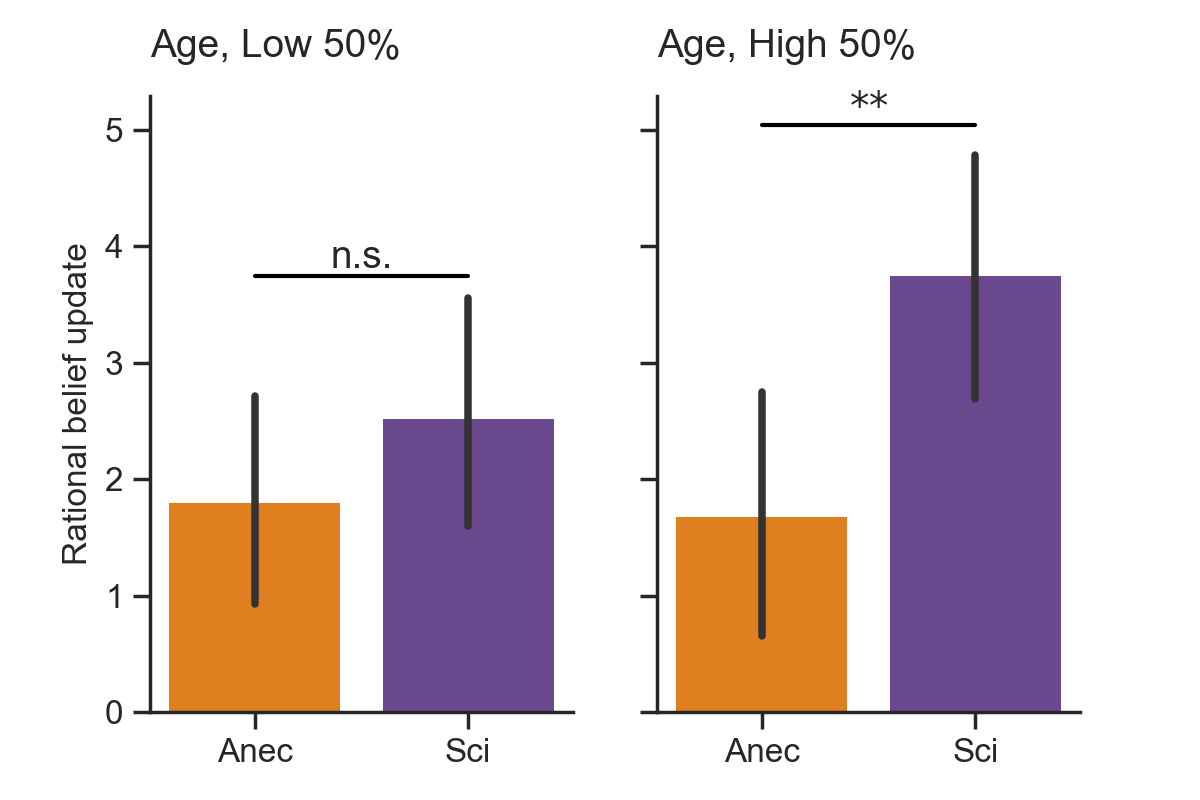

In [13]:
if "sci_anec" not in AVDATA:
    AVDATA.insert(2, "sci_anec", AVDATA["cond"].apply(lambda x: np.int(np.greater_equal(x, 1.5))))
    AVDATA.insert(2, "pop_unpop", AVDATA["cond"].apply(lambda x: np.mod(x, 2)))

# Declare groups over which to split here:
grp = "age"
lbl = [", Low 50%", ", High 50%"]
yax = "RdeltaB"

fig, ax = plt.subplots(1, 2, figsize=(6,4), sharey=True)

# Split dataframe into groups, where grpDATA is a subsampled dataframe of DATA with one split's data at a time
for name, grpDATA in AVDATA.groupby(median_split(AVDATA[grp])):
    cax = ax[int(name)]
    
    # Plotting
    sns.barplot(x="sci_anec", y=yax, data=grpDATA, \
                palette=cust_palette[0::2], linewidth = 0, edgecolor=".2", errcolor=".2", \
                ax=cax) 
    sns.despine()
    cax.set_xlabel("");
    cax.set_xticklabels(["Anec", "Sci"]);
    if int(name) == 0:
        cax.set_ylabel("Rational belief update");
    else:
        cax.set_ylabel("");
    bff.panellabel(cax, grp.title()+lbl[int(name)], fsz=14)
    
    datahandles = np.array([L.get_xydata() for L in cax.get_lines()])
    _, p = stats.ttest_ind(grpDATA.loc[grpDATA["sci_anec"]==0, yax], \
                           grpDATA.loc[grpDATA["sci_anec"]==1, yax], equal_var=False)
    bff.barplot_annotate_brackets(cax, 0, 1, p, datahandles, dh=0.05, fs=14)
    plt.savefig('figagep.tif', dpi=300, format="tiff")

# R

In [16]:
%load_ext rpy2.ipython
# %R library(lme4)
%R library(lmerTest)

import warnings
warnings.filterwarnings('ignore')

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [17]:
map_dict = {0: "AP", 1: "AU", 2: "SP", 3: "SU"}
if "IC" in DATA:
    DATA = DATA.drop("IC", axis=1)
DATA.insert(8,"IC",DATA["cond"].map(map_dict))
DATA.head()

,RdeltaB,convincing,cond,itemnum,age,party,twitter,trust,IC,partnum
0,-3.0,77.0,2.0,0.0,19.0,1.0,0.0,89.0,SP,0.0
1,14.0,17.0,1.0,1.0,19.0,1.0,0.0,89.0,AU,0.0
2,14.0,44.0,2.0,2.0,19.0,1.0,0.0,89.0,SP,0.0
3,-13.0,15.0,0.0,3.0,19.0,1.0,0.0,89.0,AP,0.0
4,-2.0,59.0,0.0,4.0,19.0,1.0,0.0,89.0,AP,0.0


In [18]:
%Rpush DATA

In [19]:
%%R

M <- lmer(RdeltaB ~ -1 + IC + (1 | partnum) + (1 | itemnum), data = DATA)
print(summary(M))

rfs <- ranef(M)$partnum
ffs <- fixef(M)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RdeltaB ~ -1 + IC + (1 | partnum) + (1 | itemnum)
   Data: DATA

REML criterion at convergence: 54762.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.8996 -0.4454 -0.0402  0.4422  5.6806 

Random effects:
 Groups   Name        Variance Std.Dev.
 partnum  (Intercept)   9.001   3.000  
 itemnum  (Intercept)   3.938   1.985  
 Residual             296.512  17.220  
Number of obs: 6400, groups:  partnum, 200; itemnum, 32

Fixed effects:
     Estimate Std. Error       df t value Pr(>|t|)    
ICAP   2.8269     0.5964 130.2476   4.740 5.52e-06 ***
ICAU   0.7776     0.5958 129.7668   1.305    0.194    
ICSP   3.5458     0.5965 130.3832   5.944 2.39e-08 ***
ICSU   2.5149     0.5969 130.6523   4.213 4.66e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
     ICAP  ICAU  ICSP 
ICAU 0.471            
ICSP 0.471 0.471      
ICSU 0.4